In [1]:
!pip install pyspark findspark

In [5]:
import findspark
findspark.init()

In [6]:
import os
import pyspark
from pyspark.sql import SparkSession

import pyspark.sql.types as ptypes
import pyspark.sql.functions as funcs

In [7]:
import pyspark
from pyspark.sql import SparkSession

ss = pyspark.sql.SparkSession.builder.master('local[*]').appName('Sales').getOrCreate()

In [8]:
# Updating matpotlib configuration to change figure size

%matplotlib inline
%config InlineBackend.rc = {'figure.figsize': (16, 8)}

In [9]:
sales_path = f'{os.path.abspath(os.path.pardir)}/Data_Analytics/SalesAnalysis.csv'
sales_data = ss.read.csv(sales_path, inferSchema=True, header=True)


In [10]:
# Dropping null rows
sales_data_dropna = sales_data.dropna()

In [11]:
# Cleaning `Order Date` column

import pyspark.sql.functions as funcs

sales_data_dropna = (sales_data_dropna. withColumn('Order Date', funcs.from_unixtime(funcs.unix_timestamp('Order Date', 'MM/dd/yy HH:mm'))))

In [12]:
import pyspark.sql.types as ptypes

sales_data_dropna = (sales_data_dropna
                     .withColumn('hour', funcs.date_format(sales_data_dropna['Order Date'], 'HH').cast(ptypes.IntegerType()))
                     .withColumn('minute', funcs.date_format(sales_data_dropna['Order Date'], 'mm').cast(ptypes.IntegerType()))
                     .withColumn('full_weekday', funcs.date_format(sales_data_dropna['Order Date'], 'EEEE'))
                     .withColumn('month_ordered', funcs.date_format(sales_data_dropna['Order Date'], 'MMM')))

In [13]:
# Total number of products sold per month

%matplotlib inline
%config InlineBackend.rc = {'figure.figsize': (16, 8)}

<Axes: xlabel='Month', ylabel='Quantity'>

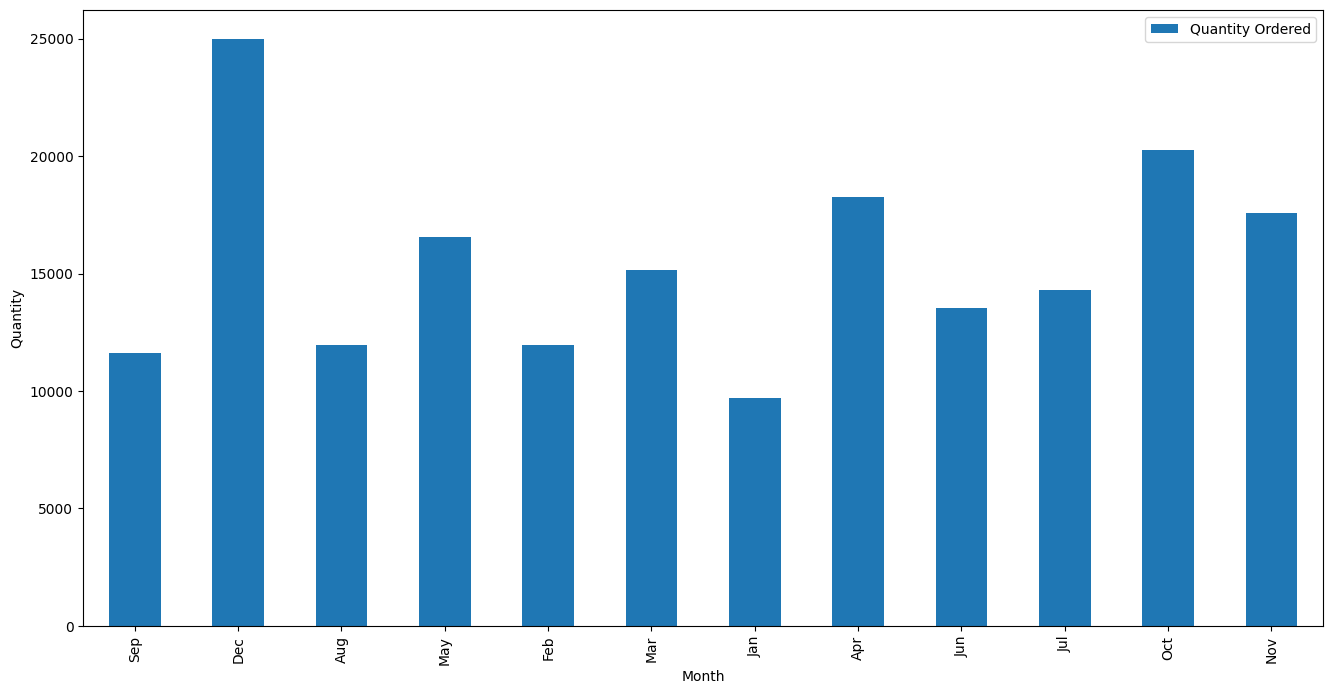

In [14]:
(sales_data_dropna.groupby('month_ordered')
 .agg(
     funcs.count(funcs.col('Quantity Ordered')).alias('Quantity Ordered')
 ).toPandas().plot(kind='bar', x='month_ordered', xlabel="Month", ylabel='Quantity')
)

In [15]:
#### Product sold per month

sales_data_dropna = sales_data_dropna.withColumn('total_pay', (funcs.col('Price Each') * funcs.col('Quantity Ordered')))
monthly_highest_sales = sales_data_dropna.groupby('month_ordered').sum('total_pay').alias('monthly_total')
monthly_highest_sales = monthly_highest_sales.withColumnRenamed('sum(total_pay)', 'monthly_total')

<Axes: xlabel='Month', ylabel='Sales in USD ($)'>

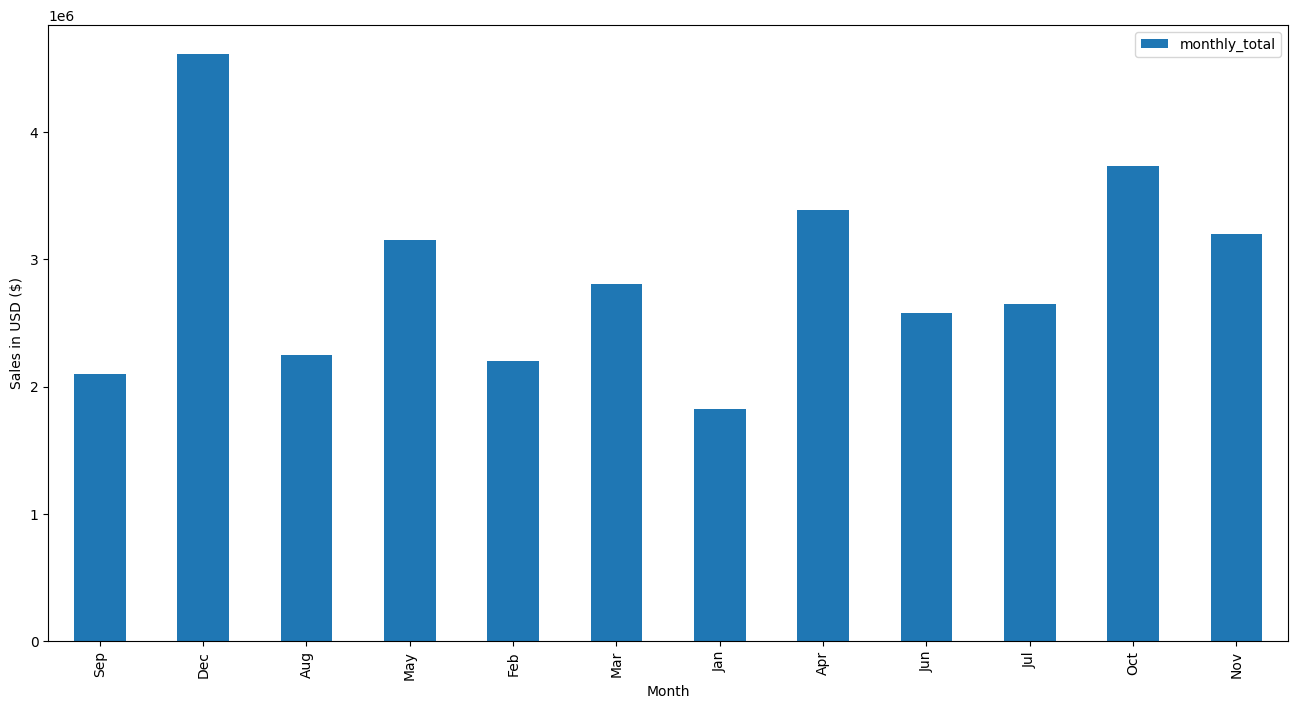

In [16]:
(monthly_highest_sales.toPandas()
 .plot(kind='bar', x='month_ordered', xlabel='Month', ylabel='Sales in USD ($)'))

<Axes: xlabel='Products', ylabel='Quantity Ordered'>

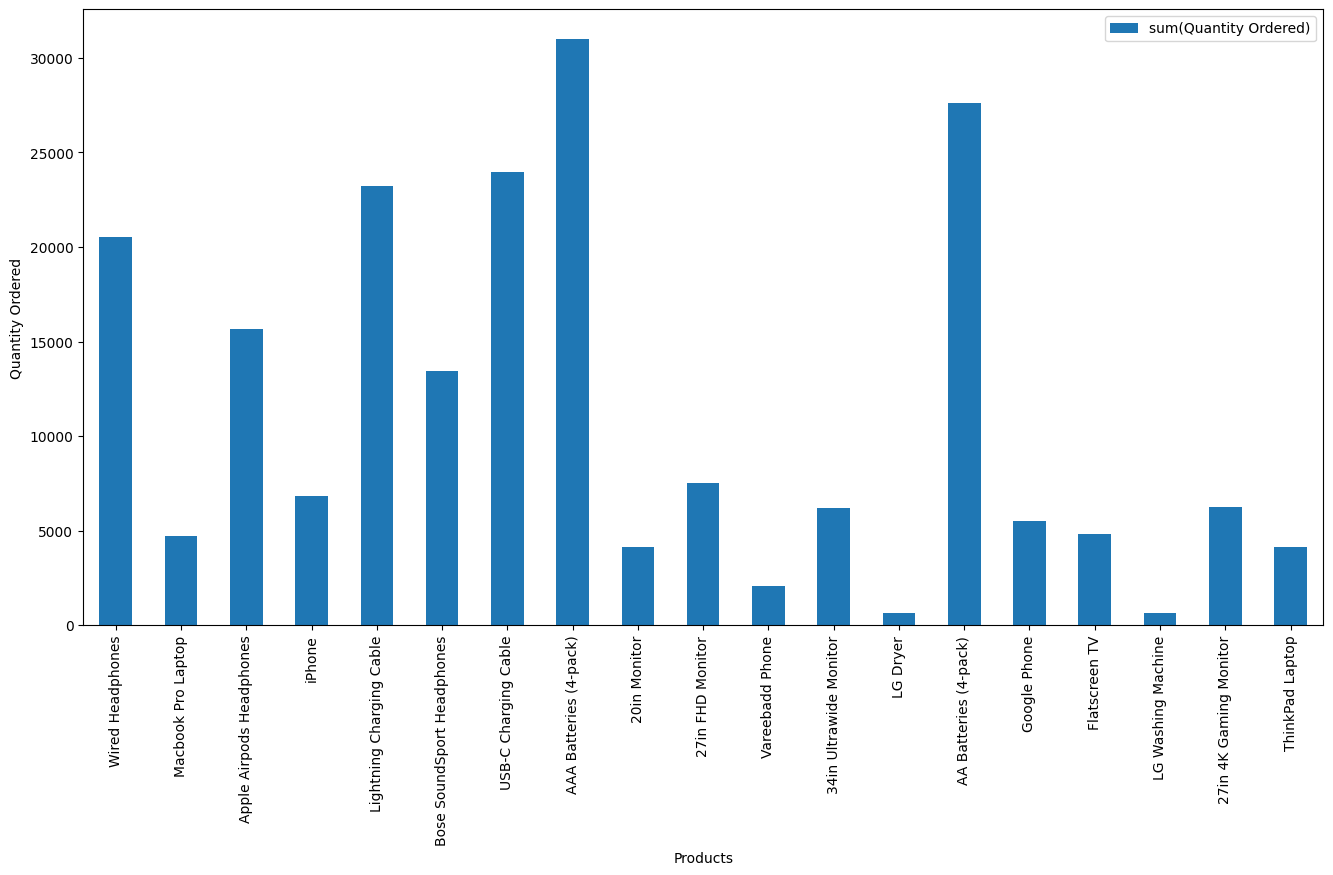

In [17]:
# Group by 'Product' and sum the 'Quantity Ordered' column
product_quantity = sales_data_dropna.groupBy('Product').agg({'Quantity Ordered': 'sum'})

# Convert the Spark DataFrame to a Pandas DataFrame for plotting
product_quantity_pandas = product_quantity.toPandas()

# Plot the results as a bar chart
product_quantity_pandas.plot(kind='bar', x='Product', xlabel='Products', ylabel='Quantity Ordered')


In [23]:
# Defining `UDF` function to clean address

def clean_addresss(address):
    city = address.split(',')[1].strip()
    state = address.split(',')[2].split(' ')[1].strip()
    return f'{city} ({state})'

clean_addresss_udf = funcs.udf(lambda addrs: clean_addresss(addrs))

In [24]:
# Cleaning address
sales_data_dropna = sales_data_dropna.withColumn('city', clean_addresss_udf('Purchase Address'))

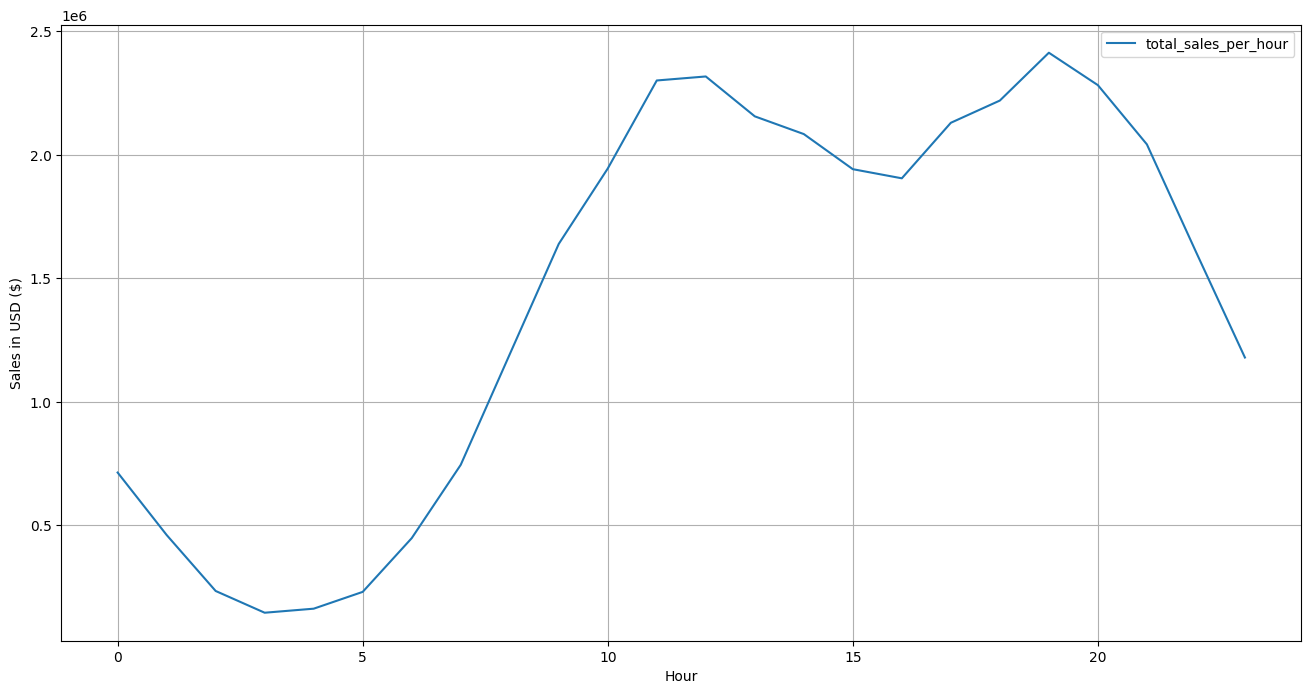

In [21]:
# Max sales during specific hour
(sales_data_dropna.groupby('hour')
 .sum('total_pay').withColumnRenamed('sum(total_pay)', 'total_sales_per_hour')
 .sort('hour').toPandas().plot(x='hour', xlabel='Hour', ylabel='Sales in USD ($)')
 .grid())

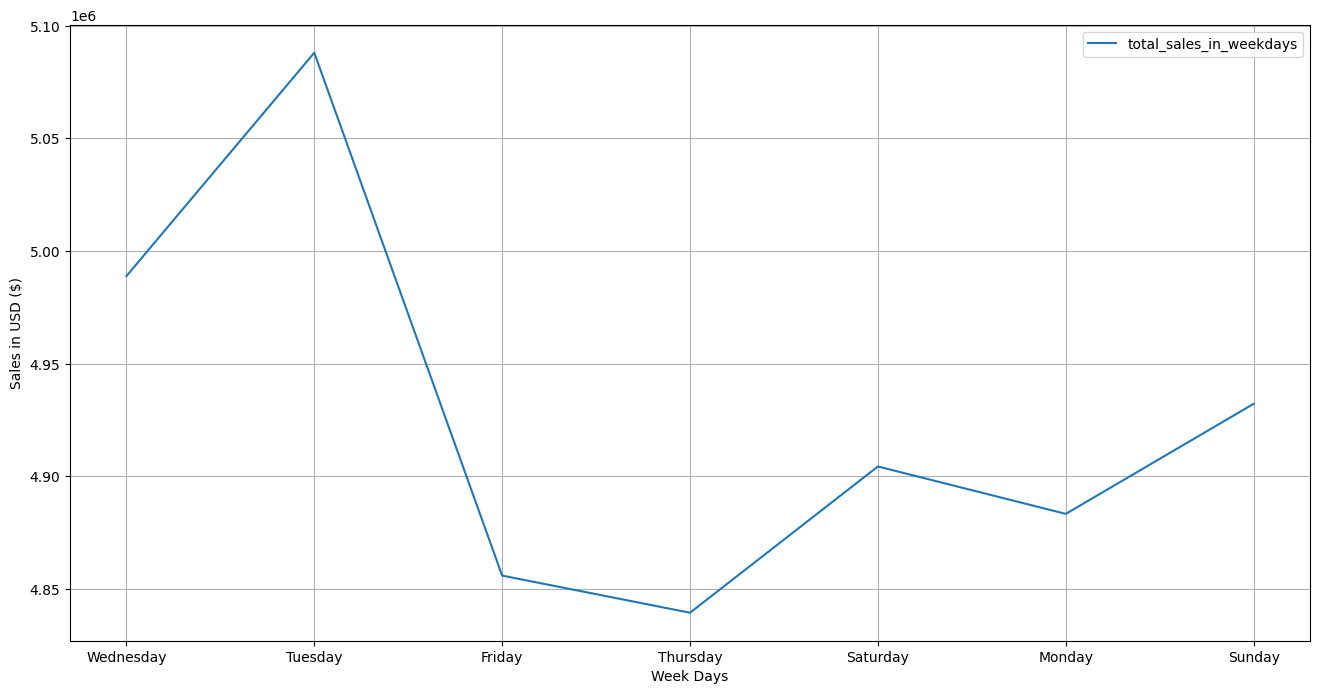

In [26]:
# Find the day of week for entire year which has max product selling.

(sales_data_dropna.groupby('full_weekday').sum('total_pay')
 .withColumnRenamed('sum(total_pay)', 'total_sales_in_weekdays')
 .toPandas().plot(x='full_weekday', xlabel='Week Days', ylabel='Sales in USD ($)')
 .grid())